In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import os

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class setup:
    # first part
    
    H = 1210 # mm
    lambd = 532 * 10**-9 # nm 

    #second part

    L = 120.4     # cm
    a1 = 130      # mm
    b1_a2 = 670   # mm
    b2 = 580      # mm

    F1 = 130 # mm
    F2 = 25 # mm

    H_err = 10 # mm
    x_err = 1 # mm
    D_err = 0.01 # mm

In [3]:
data = mipt.read_excel('dat/433.xlsx', usecols=['B', 'C', 'D', 'E', 'F', 'G', 'K', 'L', 'M', 'N', 'Q', 'R', 'S', 'T'], nrows=14).dropna(how='all')
data

,1up,2up,3up,1do,2do,3do,2up.1,3up.1,2do.1,3do.1,2up.2,3up.2,2do.2,3do.2
0,133.0,133.0,133.0,133.0,107.0,132.0,10.0,50.0,10.0,30.0,3.78,1.23,3.69,1.15
1,2.0,5.0,10.0,2.0,4.0,10.0,6.0,14.0,5.0,7.0,NaN,NaN,NaN,NaN


In [4]:
xsl = {
    "1up" : "1up",
    "2up" : "2up",
    "3up" : "3up",
    "1do" : "1do",
    "2do" : "2do",
    "3do" : "3do",
    
    "2up.1" : "2up_period",
    "3up.1" : "3up_period",
    "2do.1" : "2do_period",
    "3do.1" : "3do_period",

    "2up.2" : "2up_D",
    "3up.2" : "3up_D",
    "2do.2" : "2do_D",
    "3do.2" : "3do_D"
    
}

data = mipt.map_excel(data, xsl)
data

,1up,2up,3up,1do,2do,3do,2up_period,3up_period,2do_period,3do_period,2up_D,3up_D,2do_D,3do_D
0,133.0,133.0,133.0,133.0,107.0,132.0,10.0,50.0,10.0,30.0,3.78,1.23,3.69,1.15
1,2.0,5.0,10.0,2.0,4.0,10.0,6.0,14.0,5.0,7.0,NaN,NaN,NaN,NaN


In [5]:
up1 = data['1up'].dropna()
up2 = data['2up'].dropna()
up3 = data['3up'].dropna()

down1 = data['1do'].dropna()
down2 = data['2do'].dropna()
down3 = data['3do'].dropna()

up2_per = data['2up_period'].dropna()
up3_per = data['3up_period'].dropna()

down2_per = data['2do_period'].dropna()
down3_per = data['3do_period'].dropna()

up2_D = data['2up_D'].dropna()
up3_D = data['3up_D'].dropna()

down2_D = data['2do_D'].dropna()
down3_D = data['3do_D'].dropna()


$$d sin(\theta) = m \lambda$$
$$sin(\theta) \approx \theta \approx tg(\theta) = \frac{x}{H}$$
$$d = \frac{m \lambda H}{x}$$

In [6]:
d_raw = []
d_raw_err = []

d_raw.append(up1[1] * setup.H * setup.lambd / up1[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / up1[0])**2))

d_raw.append(up2[1] * setup.H * setup.lambd / up2[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / up2[0])**2))

d_raw.append(up3[1] * setup.H * setup.lambd / up3[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / up3[0])**2))

d_raw.append(down1[1] * setup.H * setup.lambd / down1[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / down1[0])**2))

d_raw.append(down2[1] * setup.H * setup.lambd / down2[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / down2[0])**2))

d_raw.append(down3[1] * setup.H * setup.lambd / down3[0]) # in mkm
d_raw_err.append(d_raw[len(d_raw) - 1] * np.sqrt((setup.H_err / setup.H)**2 + (setup.x_err / down3[0])**2))

d = np.array(d_raw)
print(f"d = {d * 10**6} mkm")

d_err = np.array(d_raw_err)
print(f"d_err = {d_err * 10**6} mkm")

d = [ 9.68       24.2        48.4         9.68       24.06429907 48.76666667] mkm
d_err = [0.10815365 0.27038414 0.54076827 0.10815365 0.30022103 0.54673817] mkm


$$a_2 = \frac{b_2 F_2}{b_2 - F_2}$$
$$\Gamma = \frac{b_1 b_2}{a_1 a_2}$$
$$d = \frac{x}{n \Gamma}$$

In [7]:
a2 = setup.b2 * setup.F2 / (setup.b2 - setup.F2)
print(f"a2 = ({a2} +- 1) mm")

a2 = (26.126126126126128 +- 1) mm


In [8]:
Gamma = (setup.b1_a2 - a2) * setup.b2 / (setup.a1 * a2)
Gamma_err = Gamma * np.sqrt((setup.x_err / (setup.b1_a2 - a2)) ** 2 + (setup.x_err / (setup.b2)) ** 2 + (setup.x_err / (setup.a1)) ** 2 + (setup.x_err / (a2)) ** 2)
print(f"$\Gamma$ = ({Gamma} +- {Gamma_err})")

$\Gamma$ = (109.95384615384616 +- 4.300303193495236)


In [9]:
d_per_raw = []
d_per_raw_err = []

d_per_raw.append(up2_per[0] / (up2_per[1] * Gamma))
d_per_raw_err.append(d_per_raw[len(d_per_raw) - 1] * np.sqrt((setup.x_err / up2_per[0]) ** 2) + (Gamma_err / Gamma) ** 2)

d_per_raw.append(up3_per[0] / (up3_per[1] * Gamma))
d_per_raw_err.append(d_per_raw[len(d_per_raw) - 1] * np.sqrt((setup.x_err / up3_per[0]) ** 2) + (Gamma_err / Gamma) ** 2)

d_per_raw.append(down2_per[0] / (down2_per[1] * Gamma))
d_per_raw_err.append(d_per_raw[len(d_per_raw) - 1] * np.sqrt((setup.x_err / down2_per[0]) ** 2) + (Gamma_err / Gamma) ** 2)

d_per_raw.append(down3_per[0] / (down3_per[1] * Gamma))
d_per_raw_err.append(d_per_raw[len(d_per_raw) - 1] * np.sqrt((setup.x_err / down3_per[0]) ** 2) + (Gamma_err / Gamma) ** 2)

d_per = np.array(d_per_raw)
print(f"d = {d_per * 10**3} mkm")

d_per_err = np.array(d_per_raw_err)
print(f"d_err = {d_per_err * 10**3} mkm")

d = [15.1578751  32.48116093 18.18945012 38.97739311] mkm
d_err = [3.04538549 2.1792212  3.348543   2.82884442] mkm


$$d = \frac{2\lambda F_1}{D}$$

In [10]:
d_D_raw = []
d_D_raw_err = []

d_D_raw.append(2*setup.lambd * setup.F1/ (up2_D[0]))
d_D_raw_err.append(d_D_raw[len(d_D_raw) - 1] * setup.D_err)

d_D_raw.append(2*setup.lambd * setup.F1 / (up3_D[0]))
d_D_raw_err.append(d_D_raw[len(d_D_raw) - 1] * setup.D_err)

d_D_raw.append(2*setup.lambd * setup.F1 / (down2_D[0]))
d_D_raw_err.append(d_D_raw[len(d_D_raw) - 1] * setup.D_err)

d_D_raw.append(2*setup.lambd * setup.F1 / (down3_D[0]))
d_D_raw_err.append(d_D_raw[len(d_D_raw) - 1] * setup.D_err)

d_D = np.array(d_D_raw)
print(f"d = {d_D * 10**6 } mkm")

d_D_err = np.array(d_D_raw_err)
print(f"d_err = {d_D_err * 10**6 } mkm")

d = [ 36.59259259 112.45528455  37.48509485 120.27826087] mkm
d_err = [0.36592593 1.12455285 0.37485095 1.20278261] mkm


In [11]:
D_raw = [up2_D[0], up3_D[0], down2_D[0], down3_D[0]]
D = np.array(D_raw)
D

array([3.78, 1.23, 3.69, 1.15])

d = [24.2        48.4        24.06429907 48.76666667] mkm
k, k_err, r 42.455328660056885 1.8092765927532546 0.998188808460596


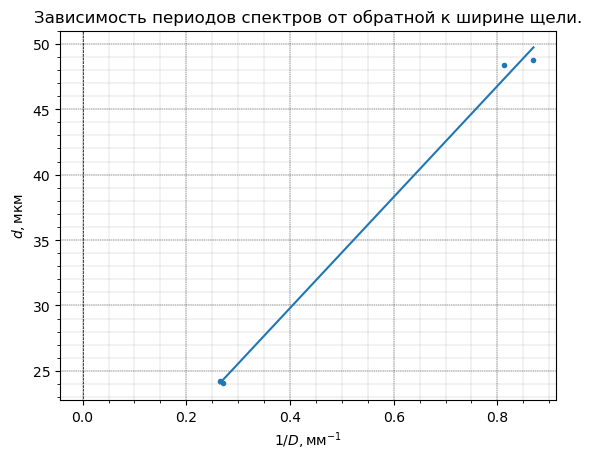

In [13]:
d_without_1up_down = np.append(d[1:3], d[4:6])
d_err_without_1up_down = np.append(d_err[1:3], d_err[4:6])

print(f"d = {d_without_1up_down * 10**6} mkm")

mipt.plot(1 / D, d_without_1up_down * 10**6)

mnk_data = mipt.mnk(1 / D, d_without_1up_down * 10**6)
k = mnk_data.get_data()["a"][0]
k_err = mnk_data.get_data()["da"][0]

r = mnk_data.get_data()["r"][0]

print("k, k_err, r", k, k_err, r)
plt.ylabel(r"$d, \text{мкм}$")
plt.xlabel(r"$1 / D, \text{мм}^{-1}$")
plt.minorticks_on()
plt.grid(which = "minor", linewidth = 0.1)
plt.grid(which = "major", linewidth = 0.3)
plt.grid(color = 'black', linestyle = '--', which = "both")
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)
plt.title("Зависимость периодов спектров от обратной к ширине щели.")


plt.savefig('gen/d_D.png')
plt.show()